In [1]:
!pip install numpy pandas matplotlib yfinance newsapi-python beautifulsoup4 lxml newspaper3k gcsfs requests
!pip install newsapi-python newspaper3k nltk textblob transformers dash
!pip install -U kaleido

In [2]:
pip install lxml_html_clean

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import plotly.graph_objects as go
import plotly.io as pio

import kaleido

In [4]:
import plotly.graph_objects as go
import yfinance as yf


def candlesticks(stock):
    # Download historical data for a stock
    stock_data = yf.download(stock, start='2023-01-01', end='2023-12-31')


    # Create the candlestick chart
    fig = go.Figure(data=[go.Candlestick(
        x=stock_data.index,
        open=stock_data['Open'],
        high=stock_data['High'],
        low=stock_data['Low'],
        close=stock_data['Close'],
        increasing_line_color= 'green', decreasing_line_color= 'red'
        )])

    fig.update_layout(title=stock,
                      xaxis_title='Date',
                      yaxis_title='Price (USD)',
                      xaxis_rangeslider_visible=False)

    fig.show()

    with open('static/candlesticks.png', 'wb') as f:
        f.write(fig.to_image(format="png"))

[*********************100%%**********************]  1 of 1 completed


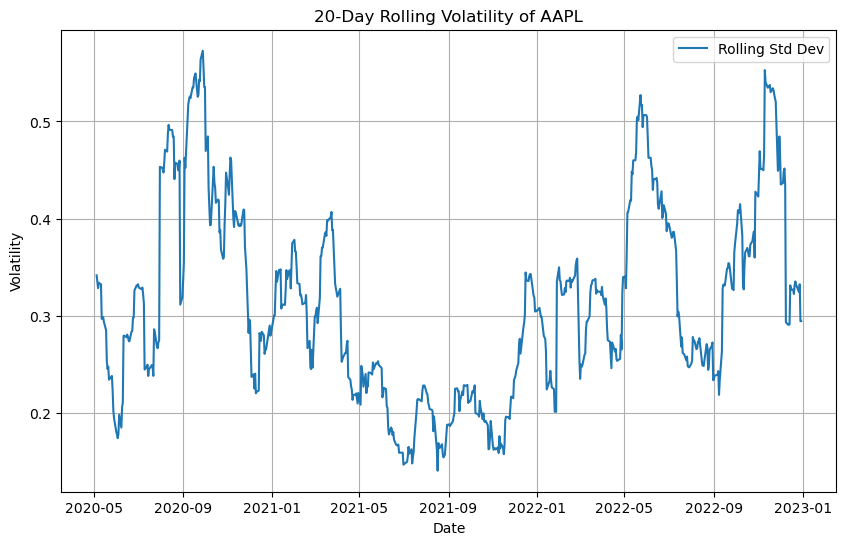

In [5]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

def volatility(stock):

    # Fetch stock data
    data = yf.download(stock, start='2020-04-06', end='2023-01-01')
    data['Returns'] = data['Adj Close'].pct_change()
    data['Volatility'] = data['Returns'].rolling(window=20).std() * np.sqrt(252)  # Annualized volatility

    # Plot Volatility
    plt.figure(figsize=(10, 6))
    plt.plot(data['Volatility'], label='Rolling Std Dev')
    plt.title('20-Day Rolling Volatility of '+stock)
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.savefig("static/volatility.png")  # Save the plot before displaying
    plt.show()

volatility("AAPL")  # Example usage


In [6]:

def plotmacd(stock):
    data = yf.download('AAPL', start='2020-04-06', end='2023-01-01')
    exp1 = data['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Adj Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    plt.figure(figsize=(10, 6))
    plt.plot(macd, label='MACD', color='blue')
    plt.plot(signal, label='Signal Line', color='red')
    plt.title('MACD for AAPL')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()
    plt.grid(True)
    plt.savefig("static/macd.png")
    plt.show()

In [7]:
# Function to fetch and process financial data
def fetch_and_process_financial_data(stock, start_date, end_date):
    data = yf.download(stock, start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(window=5).mean()  # Short-term SMA
    return data


def plot_data_with_sentiment(stock_data, sentiments, title='Stock Prices and Sentiment'):
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['Close'], label='Close Price', color='blue')
    plt.plot(stock_data['SMA'], label='5-Day SMA', color='red')

    #Safe normalization of sentiment scores
    if sentiments.size > 0 and not np.isnan(sentiments).all():
        min_sentiment = sentiments.min()
        max_sentiment = sentiments.max()
        if min_sentiment != max_sentiment:
            normalized_sentiment = (sentiments - min_sentiment) / (max_sentiment - min_sentiment)
            plt.fill_between(stock_data.index, stock_data['Close'].min(), stock_data['Close'],
                             color='gray', alpha=0.3 * normalized_sentiment)
        else:
            
            plt.fill_between(stock_data.index, stock_data['Close'].min(), stock_data['Close'],
                             color='gray', alpha=0.3)
    else:
        print("No valid sentiment data available for plotting.")

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig("static/sentiment.png")


In [8]:
def analyze_sentiment_of_news(api_key, query):
    newsapi = NewsApiClient(api_key=api_key)
    headlines = newsapi.get_everything(q=query, language='en', sort_by='relevancy', page_size=10)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

    sentiments = []
    for article in headlines['articles']:
        text = Article(article['url']).text
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs)
        sentiments.append(outputs.logits.softmax(dim=-1).numpy()[0, 1])  # Assuming class 1 is positive sentiment
    return pd.Series(sentiments, index=pd.to_datetime([article['publishedAt'] for article in headlines['articles']]))


In [9]:

def generatesentimentandstockchart(stock):
    start_date = datetime.now() - timedelta(days=60)
    end_date = datetime.now()
    stock_data = fetch_and_process_financial_data(stock, start_date, end_date)
    api_key = '288b1f10cfff45078a49cd08d309c496'
    sentiments = analyze_sentiment_of_news(api_key, stock)
    plot_data_with_sentiment(stock_data, sentiments)

In [10]:
import os
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


static_dir = 'static'

if not os.path.exists(static_dir):
    os.makedirs(static_dir)


top_50_symbols = ["AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "META", "TSLA", "BRK-A", "BRK-B", "JNJ",
                  "JPM", "NVDA", "V", "PYPL", "PG", "HD", "MA", "INTC", "DIS", "UNH", "CRM", "BAC",
                  "NFLX", "CMCSA", "ADBE", "NKE", "T", "ABT", "XOM", "VZ", "KO", "PEP", "MRK", "CSCO",
                  "WMT", "CVX", "TMO", "COST", "AVGO", "ACN", "AMGN", "MDT", "NEE", "QCOM", "UNP", "LLY",
                  "TXN", "LIN"]


all_stock_data = {}
for symbol in top_50_symbols:
    stock_data = yf.download(symbol, start="2020-01-01", end="2021-01-01")
    all_stock_data[symbol] = stock_data


returns = {}
risk = {}
for symbol, stock_data in all_stock_data.items():
    stock_data['Returns'] = stock_data['Adj Close'].pct_change()
    returns[symbol] = np.mean(stock_data['Returns'])
    risk[symbol] = np.std(stock_data['Returns'])

plt.figure(figsize=(12, 8))
for symbol in top_50_symbols:
    if symbol in ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "NVDA", "JPM", "V", "BAC", "DIS"]:
        plt.scatter(risk[symbol], returns[symbol], label=symbol, alpha=0.7)
    else:
        plt.scatter(risk[symbol], returns[symbol], alpha=0.7)

plt.title('Expected Risk vs Returns - Top 50 Stocks of S&P 500')
plt.xlabel('Risk (Standard Deviation of Returns)')
plt.ylabel('Average Return')
plt.legend(markerscale=2, bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.grid(True)


plt.savefig(os.path.join(static_dir, "riskreward.png"))
plt.close()  #Close the plot to free up memory

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [11]:
import yfinance as yf
import matplotlib.pyplot as plt

def dividends(stock_symbol):
    stock_data = yf.Ticker(stock_symbol)

    dividends = stock_data.dividends
    dividends_last_5_years = dividends.tail(20) 
    
    plt.figure(figsize=(10, 6))
    plt.bar(dividends_last_5_years.index, dividends_last_5_years, color='blue')
    plt.title(f'{stock_symbol} Dividends Over the Last 5 Years')
    plt.xlabel('Date')
    plt.ylabel('Dividends')
    plt.grid(True)
    plt.savefig("static/dividends.png")
    plt.show()


In [12]:
!pip install bottle
import yfinance as yf

In [13]:
!pip install torch
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from newsapi import NewsApiClient
from newspaper import Article
import nltk
nltk.download('punkt')

def recommendation_analysis(stock_name):

    stock_data = yf.download(stock_name, start="2022-04-15", end="2024-04-15")
    stock_data['Signal'] = np.where(stock_data['Close'].shift(-1) > stock_data['Close'], 1, -1)


    X = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].iloc[:-1].values
    y = stock_data['Signal'].iloc[:-1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.fit(X_train, y_train)

    rf_predictions = rf_classifier.predict(X_test)

    print("Random Forest Classifier Report:\n", classification_report(y_test, rf_predictions))
    print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [4, 5, 6, None],
        'criterion': ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print("Best parameters for random forest:", grid_search.best_params_)

    rf_classifier = RandomForestClassifier(**grid_search.best_params_, random_state=42)
    rf_classifier.fit(X_train, y_train)
    rf_predictions = rf_classifier.predict(X_test)
    print("Optimized random forest accuracy:", accuracy_score(y_test, rf_predictions))

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def fetch_news(api_key, query):
        newsapi = NewsApiClient(api_key=api_key)
        try:
            headlines = newsapi.get_everything(q=query, language='en', sort_by='relevancy', page_size=100)
            return headlines['articles']
        except Exception as e:
            return []

    def get_article_text(url):
        article = Article(url)
        try:
            article.download()
            article.parse()
        except Exception as e:
            return None
        return article.text

    def analyze_sentiment_bert(text):
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        outputs = model(**inputs)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()
        sentiment_score = (predicted_label - 1) / 2.0
        return sentiment_score

    api_key = '288b1f10cfff45078a49cd08d309c496'  # Replace with your actual NewsAPI key
    articles = fetch_news(api_key, stock_name)

    sentiments_bert = []
    for article in articles:
        text = get_article_text(article['url'])
        if text:
            sentiment = analyze_sentiment_bert(text)
            sentiments_bert.append(sentiment)

    if sentiments_bert:
        average_sentiment_bert = sum(sentiments_bert) / len(sentiments_bert)
        print("Average Sentiment (BERT):", average_sentiment_bert)
        return average_sentiment_bert
    else:
        print("No sentiments to analyze due to errors.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def fetch_prices(stock, start_date, end_date):
    stock_data = yf.download(stock,start=start_date, end=end_date)
    return stock_data

def calculate_sma(prices, window=25):
#calculate sma
    sma = prices['Close'].rolling(window=window).mean()
    return sma

def plot_sma(prices, sma):
#plotting
    plt.figure(figsize=(14, 7))
    plt.plot(prices['Close'], label='Stock Price', color='blue')
    plt.plot(sma, label='Simple Moving Average', color='red')
    plt.title(f'Stock Price and SMA Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.savefig("static/sma.png")
    plt.show()


def plotsma(stock) :
    start_date = datetime.now() - timedelta(days=60)
    end_date = datetime.now()
    prices =fetch_prices(stock,start_date,end_date)
    sma =calculate_sma(prices, window=5)
    plot_sma(prices, sma)


In [15]:
def make_recommendation(stock_name):
#recommendation function
    stock_sentiment = recommendation_analysis(stock_name)
    start_date = datetime.now() - timedelta(days=60)
    end_date = datetime.now()
    prices =fetch_prices(stock_name,start_date,end_date)
    sma =calculate_sma(prices, window=5)
    if stock_sentiment > 0 and (sma[-1] > sma[-2]):
        return 'Buy'
    elif stock_sentiment < 0 and (sma[-2] < sma[-1]):
        return 'Sell'
    else:
        return 'Hold'

In [ ]:
from bottle import Bottle, run, template, request
from bottle import static_file

app = Bottle()


@app.route('/static/<filename:path>')
def send_static(filename):
    return static_file(filename, root='static')

@app.route('/', method='GET')
def index():
    print("Index function called")  # Add this line
    print("Start")
    return '''
   <!DOCTYPE html>
   <html>
   <head>
    <title>Stock Market Dashboard</title>
    <link rel="stylesheet" type="text/css" href="/static/form_style.css">
    </head>
    <body>
    <h1>Stock Market Dashboard</h1>
    <form action="/stock_data" method="post">
        <label for="stock_name">Enter Stock Name:</label><br>
        <input type="text" id="stock_name" name="stock_name"><br><br>
        <input type="submit" value="Submit">
    </form>
    </body>
    </html>
    '''


@app.route('/stock_data', method='POST')
def get_stock_data():
    stock_name = request.forms.get('stock_name')
    print("Received stock name:", stock_name)

    try:
        #Fetch data from Yahoo Finance
        stock_data = yf.Ticker(stock_name)
        print("Fetched stock data successfully")
    except Exception as e:
        print("Error fetching stock data:", e)
        return f"Error fetching stock data: {e}"

    try:
        stock_info = stock_data.info
        print("Retrieved stock info successfully")

        hist = stock_data.history(period="1mo")
        print("Retrieved historical market data successfully")

        actions = stock_data.actions
        _dividends = stock_data.dividends
        splits = stock_data.splits
        capital_gains = stock_data.capital_gains
        print("Retrieved actions successfully")

        shares_full = stock_data.get_shares_full(start="2022-01-01", end=None)
        print("Retrieved share count successfully")

        
        income_stmt = stock_data.income_stmt
        quarterly_income_stmt = stock_data.quarterly_income_stmt
        balance_sheet = stock_data.balance_sheet
        quarterly_balance_sheet = stock_data.quarterly_balance_sheet
        cashflow = stock_data.cashflow
        quarterly_cashflow = stock_data.quarterly_cashflow
        print("Retrieved financial data successfully")

        
        major_holders = stock_data.major_holders
        institutional_holders = stock_data.institutional_holders
        mutualfund_holders = stock_data.mutualfund_holders
        insider_transactions = stock_data.insider_transactions
        insider_purchases = stock_data.insider_purchases
        insider_roster_holders = stock_data.insider_roster_holders
        print("Retrieved holder data successfully")

        recommendations = stock_data.recommendations
        recommendations_summary = stock_data.recommendations_summary
        upgrades_downgrades = stock_data.upgrades_downgrades
        print("Retrieved recommendations successfully")

        earnings_dates = stock_data.earnings_dates
        print("Retrieved earnings dates successfully")

        isin = stock_data.isin
        print("Retrieved ISIN code successfully")

        options = stock_data.options
        print("Retrieved options expirations successfully")

        #Show news
        news = stock_data.news
        print("Retrieved news successfully")

        #generate graphs
        print("Generating graphs...")
        dividends(stock_name)
        volatility(stock_name)
        candlesticks(stock_name)
        generatesentimentandstockchart(stock_name)
        plotmacd(stock_name)
        plotsma(stock_name)
    
        print("Graphs generated successfully")
        recommendation = make_recommendation(stock_name)

    except Exception as e:
        print("Error:", e)
      

    return template(html_template,
                    hist=hist,
                    actions=actions,
                    _dividends=_dividends,
                    splits=splits,
                    capital_gains=capital_gains,
                    income_stmt=income_stmt,
                    quarterly_income_stmt=quarterly_income_stmt,
                    balance_sheet=balance_sheet,
                    quarterly_balance_sheet=quarterly_balance_sheet,
                    cashflow=cashflow,
                    quarterly_cashflow=quarterly_cashflow,
                    major_holders=major_holders,
                    institutional_holders=institutional_holders,
                    mutualfund_holders=mutualfund_holders,
                    insider_transactions=insider_transactions,
                    insider_purchases=insider_purchases,
                    recommendations=recommendations,
                    recommendations_summary=recommendations_summary,
                    upgrades_downgrades=upgrades_downgrades,
                    earnings_dates=earnings_dates,
                    isin=isin,
                    options=options,
                    news=news,
                    recommendation = recommendation)


#HTML template
html_template = '''
<!DOCTYPE html>
<html>
<head>
    <title>Stock Market Dashboard</title>
    <link rel="stylesheet" type="text/css" href="/static/style.css">
</head>
<body>

    <div class="header">
        <h1>Stock Market Dashboard</h1>
    </div>

    <div class="recommendation">
        <h2>Recommendation: {{recommendation}}</h2>
    </div>

    <div class="container">
        <div class="charts">
            <div class="chart">
                <img src="static/macd.png" alt="MACD Chart">
                <h3>MACD Chart</h3>
            </div>
            <div class="chart">
                <img src="static/riskreward.png" alt="Risk Reward Chart">
                <h3>Risk Reward Chart</h3>
            </div>
            <div class="chart">
                <img src="static/volatility.png" alt="Volatility Chart">
                <h3>Volatility Chart</h3>
            </div>
            <div class="chart">
                <img src="static/candlesticks.png" alt="Candlesticks Chart">
                <h3>Candlesticks Chart</h3>
            </div>
            <div class="chart">
                <img src="static/dividends.png" alt="Dividends Chart">
                <h3>Dividends Chart</h3>
            </div>
            <div class="chart">
                <img src="static/sma.png" alt="SMA Chart">
                <h3>SMA Chart</h3>
            </div>
        </div>
    

        <div class="data">
            <details>
                <summary>Historical Market Data</summary>
                <pre>{{hist}}</pre>
            </details>

            <details>
                <summary>Income Statement</summary>
                <pre>{{income_stmt}}</pre>
            </details>

            <details>
                <summary>Balance Sheet</summary>
                <pre>{{balance_sheet}}</pre>
            </details>

            <details>
                <summary>Cash Flow Statement</summary>
                <pre>{{cashflow}}</pre>
            </details>

            <details>
                <summary>Major Holders</summary>
                <pre>{{major_holders}}</pre>
            </details>

            <details>
                <summary>Institutional Holders</summary>
                <pre>{{institutional_holders}}</pre>
            </details>

            <details>
                <summary>Mutual Fund Holders</summary>
                <pre>{{mutualfund_holders}}</pre>
            </details>
        </div>
    </div>

</body>
</html>
'''

run(app, host='localhost', port=9000)


Bottle v0.12.25 server starting up (using WSGIRefServer())...
Listening on http://localhost:9000/
Hit Ctrl-C to quit.

